# 导入包

In [ ]:
import numpy as np
import pandas as pd

import lightgbm as lgb
from scipy.stats import skew
from scipy.stats import kurtosis
from scipy.stats import mode

from tqdm import tqdm
from sklearn.model_selection import StratifiedKFold
from collections import Counter
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
import warnings 
warnings.filterwarnings("ignore")                                               

# 导入数据

In [ ]:
nrows = None

df_train = pd.read_csv('/content/drive/My Drive/Colab Notebooks/sensor_class/sensor_train.csv',sep=',',nrows=nrows)
df_test = pd.read_csv('/content/drive/My Drive/Colab Notebooks/sensor_class/sensor_test.csv',sep=',',nrows=nrows)
df_submit = pd.read_csv('/content/drive/My Drive/Colab Notebooks/sensor_class/提交结果示例.csv',sep=',',nrows=nrows)



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 合并数据

In [ ]:
df_train['acc_all'] = (df_train['acc_x'] ** 2 + df_train['acc_y'] ** 2 + df_train['acc_z'] ** 2) ** 0.5
df_train['acc_allg'] = (df_train['acc_xg'] ** 2 + df_train['acc_yg'] ** 2 + df_train['acc_zg'] ** 2) ** 0.5

In [ ]:
df_test['acc_all'] = (df_test['acc_x'] ** 2 + df_test['acc_y'] ** 2 + df_test['acc_z'] ** 2) ** 0.5
df_test['acc_allg'] = (df_test['acc_xg'] ** 2 + df_test['acc_yg'] ** 2 + df_test['acc_zg'] ** 2) ** 0.5

# 数据聚合

In [ ]:

y=df_train.groupby('fragment_id')['behavior_id'].min()

In [ ]:

from scipy.signal import resample



x = np.zeros((7292, 60, 8, 1))
t = np.zeros((7500, 60, 8, 1))
for i in tqdm(range(7292)):
  tmp = df_train[df_train.fragment_id == i][:60]
  # tmp['time_diff']=tmp['time_point'].diff(periods=1).fillna(0)
  # tmp['v_x']=tmp['acc_x']*tmp['time_diff']
  # tmp['v_y']=tmp['acc_y']*tmp['time_diff']
  # tmp['v_z']=tmp['acc_z']*tmp['time_diff']
  # tmp['v_xg']=tmp['acc_xg']*tmp['time_diff']
  # tmp['v_yg']=tmp['acc_yg']*tmp['time_diff']
  # tmp['v_zg']=tmp['acc_zg']*tmp['time_diff']
  x[i,:,:, 0] = resample(tmp.drop(['fragment_id', 'time_point', 'behavior_id'],
                                    axis=1), 60, np.array(tmp.time_point))[0]
for i in tqdm(range(7500)):
  tmp = df_test[df_test.fragment_id == i][:60]
  # tmp['time_diff']=tmp['time_point'].diff(periods=1).dropna()
  # tmp['v_x']=tmp['acc_x']*tmp['time_diff']  
  # tmp['v_y']=tmp['acc_y']*tmp['time_diff']
  # tmp['v_z']=tmp['acc_z']*tmp['time_diff']  
  # tmp['v_xg']=tmp['acc_xg']*tmp['time_diff'] 
  # tmp['v_yg']=tmp['acc_yg']*tmp['time_diff']
  # tmp['v_zg']=tmp['acc_zg']*tmp['time_diff']       
  t[i,:,:, 0] = resample(tmp.drop(['fragment_id', 'time_point'],
                                    axis=1), 60, np.array(tmp.time_point))[0]


100%|██████████| 7500/7500 [00:15<00:00, 470.25it/s]


# 模型训练 

In [ ]:
import os
import tensorflow as tf
from numpy import mean
from numpy import std
from numpy import dstack
from pandas import read_csv
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical
from matplotlib import pyplot

In [ ]:
X = x
X_test = t

In [ ]:
y=df_train.groupby('fragment_id')['behavior_id'].min()

In [ ]:
X.shape

(7292, 60, 8, 1)

# LSTM

In [ ]:
df_train_stacking = pd.DataFrame(np.zeros((X.shape[0],19)))
df_test_stacking = pd.DataFrame(np.zeros((X_test.shape[0],19)))

In [ ]:
seed = 2020
folds = 15
kfold = StratifiedKFold(n_splits=folds, shuffle=True, random_state=seed)
proba_t = np.zeros((7500, 19))

In [ ]:
layers

<module 'tensorflow.keras.layers' from '/usr/local/lib/python3.6/dist-packages/tensorflow/keras/layers/__init__.py'>

# 训练模型

In [ ]:
for fold,(train_index, val_index) in enumerate(kfold.split(X, y)):
  print('--------------- begin ---------------',fold)
  X_train, X_val = np.array(list(X[train_index])), np.array(list(X[val_index]))
  y_train, y_val = np.array(list(y[train_index])), np.array(list(y[val_index]))
    # one hot encode y
  y_train = to_categorical(y_train)
  y_val = to_categorical(y_val)
     
    # define model
  verbose, epochs, batch_size = 1, 20, 1024
  n_timesteps, n_features, n_outputs = X_train.shape[1], X_train.shape[2], y_train.shape[1]
  # reshape into subsequences (samples, time steps, rows, cols, channels)
  n_steps, n_length = 4, 15
  X_train = X_train.reshape((X_train.shape[0], n_steps, 1, n_length, n_features))
  X_val = X_val.reshape((X_val.shape[0], n_steps, 1, n_length, n_features))
 
  X_test = np.array(list(X_test))
  X_test = X_test.reshape((X_test.shape[0], n_steps, 1, n_length, n_features))
  # define model
  model = tf.keras.Sequential()
  model.add(layers.Bidirectional(layers.ConvLSTM2D(filters=64, kernel_size=(1,4), activation='relu', input_shape=(n_steps, 1, n_length, n_features), return_sequences=True)))
  
  model.add(layers.Bidirectional(layers.ConvLSTM2D(filters=128, kernel_size=(1,2), activation='relu')))
 
  
  
# model.add(layers.BatchNormalizration())
 
  model.add(layers.Dropout(0.6))
  model.add(layers.Flatten())
  model.add(layers.Dense(100, activation='relu'))
  model.add(layers.Dense(n_outputs, activation='softmax'))
  # fit network
  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
 
  plateau = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_accuracy",
                              verbose=0,
                              mode='max',
                              factor=0.1,
                              patience=6)
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',
                                  verbose=0,
                                  mode='max',
                                  patience=10)
  checkpoint = tf.keras.callbacks.ModelCheckpoint(f'./fold{fold}.h5',
                                monitor='val_accuracy',
                                verbose=0,
                                mode='max',
                                save_weights_only=True,
                                save_best_only=True)
  # model.summary()
 
  if os.path.exists(f'./fold{fold}.h5'):
      print('-------------load the model-----------------')
      model.load_weights(f'./fold{fold}.h5')
 
 
  history=model.fit(X_train, y_train, 
            epochs=epochs, 
            batch_size=batch_size, 
            verbose=verbose,
            validation_data=(X_val, y_val),
            callbacks=[plateau, early_stopping, checkpoint])
  # evaluate modelg 
  X_val_predict = model.predict(X_val)
  X_test_predict = model.predict(X_test)
    
  df_train_stacking.loc[val_index,:] = X_val_predict
  df_test_stacking[:] += X_test_predict / folds
  proba_t += model.predict(X_test, verbose=0, batch_size=1024) / 5.

  print('--------------- end ---------------')

--------------- begin --------------- 0
Epoch 1/20
7/7 [==============================] - 32s 5s/step - loss: 2.7695 - accuracy: 0.1315 - val_loss: 2.4772 - val_accuracy: 0.2115 - lr: 0.0010
Epoch 2/20
7/7 [==============================] - 31s 4s/step - loss: 2.3902 - accuracy: 0.2533 - val_loss: 2.1852 - val_accuracy: 0.2731 - lr: 0.0010
Epoch 3/20
7/7 [==============================] - 31s 4s/step - loss: 2.1164 - accuracy: 0.3199 - val_loss: 2.0148 - val_accuracy: 0.3244 - lr: 0.0010
Epoch 4/20
7/7 [==============================] - 31s 4s/step - loss: 1.9316 - accuracy: 0.3661 - val_loss: 1.9044 - val_accuracy: 0.3963 - lr: 0.0010
Epoch 5/20
7/7 [==============================] - 31s 4s/step - loss: 1.8236 - accuracy: 0.3916 - val_loss: 1.7926 - val_accuracy: 0.4292 - lr: 0.0010
Epoch 6/20
7/7 [==============================] - 31s 4s/step - loss: 1.7263 - accuracy: 0.4091 - val_loss: 1.7501 - val_accuracy: 0.4271 - lr: 0.0010
Epoch 7/20
7/7 [==============================] - 31s 

# 验证和输出结果

In [ ]:
def accuracy(y_true, y_pred):
    return tf.keras.metrics.sparse_top_k_categorical_accuracy(y_true, y_pred, k=1)

In [ ]:
def acc_combo(y, y_pred):
    # 数值ID与行为编码的对应关系
    mapping = {0: 'A_0', 1: 'A_1', 2: 'A_2', 3: 'A_3', 
        4: 'D_4', 5: 'A_5', 6: 'B_1',7: 'B_5', 
        8: 'B_2', 9: 'B_3', 10: 'B_0', 11: 'A_6', 
        12: 'C_1', 13: 'C_3', 14: 'C_0', 15: 'B_6', 
        16: 'C_2', 17: 'C_5', 18: 'C_6'}
    # 将行为ID转为编码
    code_y, code_y_pred = mapping[y], mapping[y_pred]
    if code_y == code_y_pred: #编码完全相同得分1.0
        return 1.0
    elif code_y.split("_")[0] == code_y_pred.split("_")[0]: #编码仅字母部分相同得分1.0/7
        return 1.0/7
    elif code_y.split("_")[1] == code_y_pred.split("_")[1]: #编码仅数字部分相同得分1.0/3
        return 1.0/3
    else:
        return 0.0

In [ ]:
pred_y = np.argmax(df_train_stacking.values, axis=1)


acc_scores = round(accuracy_score(y, pred_y), 5)
acc_combo_scores = round(sum(acc_combo(y_true, y_pred) for y_true, y_pred in zip(y, pred_y)) / len(list(y)),5)

print('--------')
print(' acc : ', acc_scores, 'acc_combo : ', acc_combo_scores)

df_submit.behavior_id = np.argmax(proba_t, axis=1)
df_submit.to_csv('/content/drive/My Drive/Colab Notebooks/sensor_class/submit_lstm_%.5f_%.5f.csv' % (acc_scores, acc_combo_scores), index=False)

--------
 acc :  0.53593 acc_combo :  0.6017


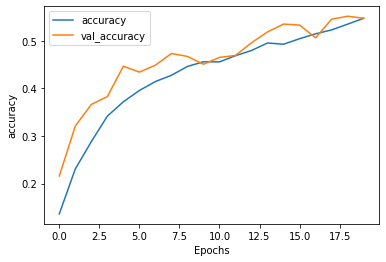

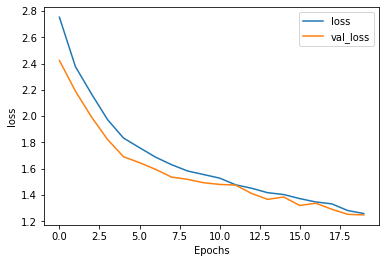

In [ ]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")